### Import packages

In [47]:
#database query
import sqlite3
import pandas as pd

#location
import zipcodes

#text cleaning
from bs4 import BeautifulSoup as bs
import re
import fasttext

#api
import requests

#misc
import numpy as np

### Query database

In [48]:
conn = sqlite3.connect("../data/db/gfm.db")

In [49]:
feed = pd.read_sql_query("SELECT * FROM feed_tb", conn)

In [50]:
donation = pd.read_sql_query("SELECT * FROM donation_tb", conn)

In [51]:
update = pd.read_sql_query("SELECT * FROM update_tb", conn)

### Select columns of interest for analysis

In [52]:
cols_to_keep = [
 'url',
 'donation_count',
 'donor_reached_max',
 'currencycode', 
 'current_amount',
 'goal_amount',
 'fund_name',
 'fund_description',
 'created_at',
 'social_share_last_update',
 'city',
 'country',
 'postal_code',
 'is_team'
]

In [53]:
feed = feed[cols_to_keep]

### Remove duplicated urls

In [54]:
original_n = feed.shape[0]

In [55]:
feed = feed.drop_duplicates('url')

In [56]:
duplicated_n = original_n - feed.shape[0]

### Extract date variables

In [57]:
feed.loc[:,'year'] = [x.split("-")[0] for x in feed['created_at']]

In [58]:
feed.loc[:,'month'] = [x.split("-")[1] for x in feed['created_at']]

### Clean location data

In [59]:
feed['city'].head()

0     Kissimmee, FL
1      New York, NY
2      Prescott, AR
3    Woodbridge, VA
4       Alachua, FL
Name: city, dtype: object

It looks like the 'city' variable is in the form 'city, state'

So we will extract the state from the city variable

In [60]:
cities_split = [x.split(",") for x in feed['city']]

def getState(d):
    results = []
    for l in d:
        if(len(l)>1):
            results.append(l[1][1:])
        else:
            results.append("NO_STATE")
    return results

states = getState(cities_split)

In [61]:
pd.Series(states).unique()

array(['FL', 'NY', 'AR', 'VA', 'TX', 'SC', 'CA', 'NC', 'PA', 'GA', 'NJ',
       'OH', 'CO', 'MA', 'IL', 'TN', 'WI', 'IN', 'NV', 'MI', 'KY', 'UT',
       'OR', 'AZ', 'WA', 'MO', 'MN', 'NM', 'CT', 'HI', 'DE', 'ID', 'WV',
       'IA', 'PR', 'AL', 'AK', 'ME', 'WY', 'OK', 'RI', 'MT', 'NO_STATE',
       'KS', 'MD', 'SD', 'NH', 'LA', 'VT', 'MS', 'NE', 'ND', 'DC',
       'Florida', 'US', 'Pa', 'VI', 'GU', 'Minnesota', 'Oregon',
       'Illinois', 'MP', 'New Hampshire', 'Cincinnati', 'S', 'AS'],
      dtype=object)

Some states are not listed as abbreviations, so convert to abbreviations

In [62]:
def AbbreviateStates(states):
    results = []
    for state in states:
        if state == "Minnesota":
            results.append('MN')
        elif state == "Florida":
            results.append('FL')
        elif state == "Oregon":
            results.append('OR')
        elif state == "Illinois":
            results.append('IL')
        elif state == "New Hampshire":
            results.append('NH')
        else:
            results.append(state)
    return results

states_abbreviated = AbbreviateStates(states)

pd.Series(states_abbreviated).unique()

array(['FL', 'NY', 'AR', 'VA', 'TX', 'SC', 'CA', 'NC', 'PA', 'GA', 'NJ',
       'OH', 'CO', 'MA', 'IL', 'TN', 'WI', 'IN', 'NV', 'MI', 'KY', 'UT',
       'OR', 'AZ', 'WA', 'MO', 'MN', 'NM', 'CT', 'HI', 'DE', 'ID', 'WV',
       'IA', 'PR', 'AL', 'AK', 'ME', 'WY', 'OK', 'RI', 'MT', 'NO_STATE',
       'KS', 'MD', 'SD', 'NH', 'LA', 'VT', 'MS', 'NE', 'ND', 'DC', 'US',
       'Pa', 'VI', 'GU', 'MP', 'Cincinnati', 'S', 'AS'], dtype=object)

In [63]:
#add variable to rest of data to inspect
feed.loc[:,'state'] = states_abbreviated

The following were inspected and zip codes were checked
- PR: Puerto Rico
- DC: Washington, DC
- Pa: Pennsylvania, seems to be coded strangely only for Canonsburg
- MP: Northern Mariana Islands
- Cincinnati: Ohio, seems to be coded strangely only for Colerain Township
- S: River Vale New Jersy
- AS: American Samoa
- GU: Guam
- VI: Virgin Islands

Will update cleaning function for Pa, Cincinnati, S

In [64]:
def AbbreviateStates_v2(states):
    results = []
    for state in states:
        if state == "Minnesota":
            results.append('MN')
        elif state == "Florida":
            results.append('FL')
        elif state == "Oregon":
            results.append('OR')
        elif state == "Illinois":
            results.append('IL')
        elif state == "New Hampshire":
            results.append('NH')
        elif state == "Pa":
            results.append('PA')
        elif state == "Cincinnati":
            results.append('OH')
        elif state == "S":
            results.append('NJ')
        else:
            results.append(state)
    return results

states_abbreviated_2 = AbbreviateStates_v2(states)

pd.Series(states_abbreviated_2).unique()

array(['FL', 'NY', 'AR', 'VA', 'TX', 'SC', 'CA', 'NC', 'PA', 'GA', 'NJ',
       'OH', 'CO', 'MA', 'IL', 'TN', 'WI', 'IN', 'NV', 'MI', 'KY', 'UT',
       'OR', 'AZ', 'WA', 'MO', 'MN', 'NM', 'CT', 'HI', 'DE', 'ID', 'WV',
       'IA', 'PR', 'AL', 'AK', 'ME', 'WY', 'OK', 'RI', 'MT', 'NO_STATE',
       'KS', 'MD', 'SD', 'NH', 'LA', 'VT', 'MS', 'NE', 'ND', 'DC', 'US',
       'VI', 'GU', 'MP', 'AS'], dtype=object)

In [65]:
#Update dataframe with new cleaned data
feed.loc[:,'state'] = states_abbreviated_2

Now investigate those with "NO_STATE"

In [66]:
feed.loc[feed['state'] == 'NO_STATE',['city','state','postal_code']].head(5)

,city,state,postal_code
187,,NO_STATE,"80528 - Fort Collins, CO"
366,VA/DC/MD,NO_STATE,22407
1131,,NO_STATE,88010
1370,,NO_STATE,92048
1407,,NO_STATE,85117


In [67]:
feed.loc[feed['state'] == 'NO_STATE',['city','state','postal_code']].tail(5)

,city,state,postal_code
99273,,NO_STATE,16
99371,,NO_STATE,2
99522,,NO_STATE,89158
99857,,NO_STATE,
99927,,NO_STATE,"00926-San Juan PR, US"


These data seem a little messy, but most have postal codes listed.

So we will run postal codes through a zipcode API to see if we can get states for these rows.

In [24]:
def ZipToState(codes):
    results = []
    for code in codes:
        try:
            r = zipcodes.matching(str(code))
            results.append(r[0]['state'])
        except:
            results.append('NO_STATE')
    return results

states_from_zip = ZipToState(feed[feed['state'] == 'NO_STATE']['postal_code'])

pd.Series(states_from_zip).value_counts()

NO_STATE    325
CO           19
VA           16
FL           11
TX            7
AP            6
AZ            4
IL            4
CA            4
MO            3
NY            3
NM            1
WI            1
GA            1
AA            1
OH            1
MD            1
NJ            1
NV            1
PR            1
NC            1
SC            1
MN            1
dtype: int64

This finds a state for a small number.

This also introduces some additional non-US states, such as PR and AP.

We will go ahead and add in the states that we were able to find with this method.

In [25]:
feed.loc[feed['state'] == 'NO_STATE', 'state'] = states_from_zip

Next we will check the state codes again, explore what these are, and apply exclusions accordingly.

In [26]:
feed['state'].unique()

array(['FL', 'NY', 'AR', 'VA', 'TX', 'SC', 'CA', 'NC', 'PA', 'GA', 'NJ',
       'OH', 'CO', 'MA', 'IL', 'TN', 'WI', 'IN', 'NV', 'MI', 'KY', 'UT',
       'OR', 'AZ', 'WA', 'MO', 'MN', 'NM', 'CT', 'HI', 'DE', 'ID', 'WV',
       'IA', 'PR', 'AL', 'AK', 'ME', 'WY', 'OK', 'RI', 'MT', 'NO_STATE',
       'KS', 'MD', 'SD', 'NH', 'LA', 'VT', 'MS', 'NE', 'ND', 'DC', 'US',
       'VI', 'GU', 'MP', 'AP', 'AA', 'AS'], dtype=object)

There are some zip codes in strings.

Extract integers from string then put through zipcode API to see if we can avoid excluding those.

In [27]:
def ZipCodeInt(codes):
    results = []
    for code in codes:
        code = str(code)
        if len(code.split()) > 1:
            try:
                code_int = [int(s) for s in code.split() if s.isdigit()][0]
                r = zipcodes.matching(str(code_int))
                results.append(r[0]['state'])
            except:
                results.append('NO_STATE')
        elif len(code.split('-')) > 1:
            try:
                code_int = [int(s) for s in code.split('-') if s.isdigit()][0]
                r = zipcodes.matching(str(code_int))
                results.append(r[0]['state'])
            except:
                results.append('NO_STATE')
        else:
            results.append('NO_STATE')
    return results

states_from_zip_string = ZipCodeInt(feed[feed['state'] == 'NO_STATE']['postal_code'])

pd.Series(states_from_zip_string).value_counts()

NO_STATE    301
FL            4
CA            4
TX            4
CO            2
NY            2
OH            2
AZ            1
ID            1
TN            1
MI            1
NV            1
IA            1
dtype: int64

This finds a few more states.

Will add these to the data.

In [28]:
feed.loc[feed['state'] == 'NO_STATE', 'state'] = states_from_zip_string

In [29]:
def GetZipCodeInt(codes):
    results = []
    for code in codes:
        code = str(code)
        if len(code.split()) > 1:
            try:
                code_int = [int(s) for s in code.split() if s.isdigit()][0]
                results.append(code_int)
            except:
                results.append(code)
        elif len(code.split('-')) > 1:
            try:
                code_int = [int(s) for s in code.split('-') if s.isdigit()][0]
                results.append(code_int)
            except:
                results.append(code)
        else:
            results.append(code)
    return results

In [30]:
feed.loc[feed['state'] == 'NO_STATE', 'postal_code'] = GetZipCodeInt(feed[feed['state'] == 'NO_STATE']['postal_code'])

In [31]:
feed['state'].unique()

array(['FL', 'NY', 'AR', 'VA', 'TX', 'SC', 'CA', 'NC', 'PA', 'GA', 'NJ',
       'OH', 'CO', 'MA', 'IL', 'TN', 'WI', 'IN', 'NV', 'MI', 'KY', 'UT',
       'OR', 'AZ', 'WA', 'MO', 'MN', 'NM', 'CT', 'HI', 'DE', 'ID', 'WV',
       'IA', 'PR', 'AL', 'AK', 'ME', 'WY', 'OK', 'RI', 'MT', 'KS', 'MD',
       'SD', 'NH', 'LA', 'VT', 'MS', 'NE', 'ND', 'DC', 'NO_STATE', 'US',
       'VI', 'GU', 'MP', 'AP', 'AA', 'AS'], dtype=object)

### Clean zip codes

In [32]:
feed['postal_code'] = feed['postal_code'].astype(str)

In [33]:
feed.loc[:,'zip_len'] = [len(x) for x in feed['postal_code']]
feed['zip_len'].value_counts()

5     85549
4      7002
3       225
0       101
1        25
10       11
7         7
6         6
2         4
9         3
12        3
17        3
21        3
24        3
13        2
11        2
19        2
20        2
25        2
15        1
26        1
16        1
8         1
18        1
22        1
35        1
Name: zip_len, dtype: int64

In [34]:
feed[feed['zip_len'] == 4]['state'].value_counts()

NJ          2170
MA          2084
CT           967
ME           624
NH           515
RI           306
VT           273
NO_STATE      38
US            25
Name: state, dtype: int64

- Most are in the northeast, where zip codes begin with 0
- Trailing zeroes are excluded from python integers
- So we will append 0 to the beginning of zip codes with length of 4

In [35]:
four_char_zip = feed[feed['zip_len'] == 4]['postal_code']
four_char_zip_new = ['0'+str(x) for x in four_char_zip]
feed.loc[feed['zip_len'] == 4,'postal_code'] = four_char_zip_new

In [36]:
#recalculate zip length, append to dataframe
feed.loc[:,'zip_len'] = [len(x) for x in feed['postal_code']]
feed['zip_len'].value_counts()

5     92551
3       225
0       101
1        25
10       11
7         7
6         6
2         4
24        3
21        3
17        3
9         3
12        3
11        2
13        2
19        2
20        2
25        2
26        1
15        1
8         1
16        1
18        1
22        1
35        1
Name: zip_len, dtype: int64

In [37]:
#exclude campaigns with zip length <5
feed = feed[feed['zip_len'] >= 5]

In [38]:
feed.shape

(92607, 18)

In [39]:
#inspect zip codes longer than 5 characters
feed.loc[feed['zip_len'] > 5,['fund_name','city','postal_code', 'state']]

,fund_name,city,postal_code,state
187,Brad Thomas' New Hope,,"80528 - Fort Collins, CO",CO
1524,for my sister,,700221,NO_STATE
2419,Urgent Medical Issue-Let’s Get Tyler Home for ...,,"Phoenix, AZ 85032",AZ
3023,Skin removal surgery after massive weightloss,,48166 newport,MI
6407,Brock's Memorial Fund,,76148-Watauga,TX
10996,Very Rare Disease Destroying Eric,,56358-3631,MN
11250,Help Maksim Kapakli fight neuroblastoma,,12183-1213,NY
15943,Fighting for Our Beautiful Arie Phillip,,"LA PLAINE, DOMINICA, 33101",FL
16596,Cathy and Brent,,L1Z0L3,NO_STATE
18271,Therapy For Bungalist,,UB40EA,NO_STATE


In [40]:
old_zips = feed.loc[feed['zip_len'] > 5,'postal_code'].tolist()

In [41]:
new_zips = [
    '80528',
    np.nan,
    '85032',
    '48166',
    '76148',
    '56358',
    '12183',
    '33101',
    np.nan,
    np.nan,
    '92704',
    '33071',
    np.nan,
    '20847',
    np.nan,
    np.nan,
    '91722',
    '78705',
    np.nan,
    '44129',
    '33015',
    '60501',
    '37347',
    '07071',
    '83631',
    np.nan,
    '29577',
    '45405',
    '76244',
    np.nan,
    np.nan,
    '33133',
    '91706',
    '98338',
    np.nan,
    '11225',
    '77479',
    '28031',
    '76705',
    np.nan,
    '81428',
    '33324',
    '13209',
    '52732',
    '78130',
    '60174',
    '30680',
    '54568',
    np.nan,
    '10012',
    '28337',
    '60803',
    np.nan,
    np.nan,
    '33616',
    '00926' 
]

In [42]:
zip_dic = {}
for i in range(len(old_zips)):
    zip_dic[old_zips[i]] = new_zips[i]

In [43]:
feed['postal_code'] = feed['postal_code'].replace(zip_dic)

In [44]:
feed['postal_code'].isna().sum()

15

In [45]:
#exclude NAs
feed = feed[~feed['postal_code'].isna()]

In [46]:
#recalculate zip length, append to dataframe
feed.loc[:,'zip_len'] = [len(x) for x in feed['postal_code']]
feed['zip_len'].value_counts()

5    92592
Name: zip_len, dtype: int64

All zip codes are length of 5 now

### Add county data

In [44]:
#HUD zip to county
hud = pd.read_excel('../data/census/ZIP_COUNTY_122020.xlsx')[['ZIP','COUNTY']]

#clean hud data
#rename columns
hud.columns = ['zip','state_county_fips']

#convert data to strings, fill zip code with leading zeros
hud['zip'] = hud['zip'].astype(str).str.zfill(5)
hud['state_county_fips'] = hud['state_county_fips'].astype(str).str.zfill(5)

In [45]:
hud.shape

(54194, 2)

In [46]:
hud['zip'].nunique()

39455

In [47]:
#some zip codes map to multiple counties
#remove duplicates so that each zip maps to one county
hud = hud.drop_duplicates('zip')
hud.shape

(39455, 2)

In [48]:
#merge hud data with feed
feed = feed.merge(hud, left_on='postal_code', right_on='zip', how='left')

In [49]:
feed['zip'].isna().sum()

250

In [50]:
feed[feed['zip'].isna()].head()

,url,donation_count,donor_reached_max,currencycode,current_amount,goal_amount,fund_name,fund_description,created_at,social_share_last_update,city,country,postal_code,is_team,year,month,state,zip_len,zip,state_county_fips
19,https://www.gofundme.com/f/basoebolacampaign,142,0,USD,12947.0,25000.0,Emergency Ebola Kits for Liberia,<strong>Background</strong><br /> We all know ...,2014-10-23T12:59:23-05:00,2017-08-31T15:59:01-05:00,"Babson Park, MA",US,02457,0,2014,10,MA,5,NaN,NaN
1125,https://www.gofundme.com/f/please-help-me-get-...,7,0,USD,365.0,5000.0,Kellough Family's New Blessing,"<img src=""https://d2g8igdw686xgo.cloudfront.ne...",2019-01-16T14:29:31-06:00,2020-08-14T08:46:21-05:00,,US,88010,0,2019,01,NO_STATE,5,NaN,NaN
1362,https://www.gofundme.com/f/covid-19-funds-for-...,34,0,USD,4065.0,5000.0,COVID 19 Funds for Feeding Families,"<strong><a href=""http://divinegm.com/""><a href...",2020-03-19T19:36:43-05:00,2020-07-28T00:01:55-05:00,,US,92048,0,2020,03,NO_STATE,5,NaN,NaN
1424,https://www.gofundme.com/f/kurtgeyer,30,0,USD,5777.0,9000.0,The Biggest Fight of Kurt's Life!,"Oh, my... Where to start? How can I accurately...",2015-08-18T07:45:49-05:00,2017-08-30T04:37:48-05:00,FPO,US,09649,0,2015,08,NO_STATE,5,NaN,NaN
1645,https://www.gofundme.com/f/loveforDiana,35,0,USD,13900.0,13500.0,Love for Diana,"Dear friends,<br /><br />We are the family and...",2016-04-28T17:11:28-05:00,2017-08-29T13:30:07-05:00,,US,97120,0,2016,04,NO_STATE,5,NaN,NaN


In [51]:
feed[feed['zip'].isna()]['state'].value_counts()

NO_STATE    133
US           23
GU           16
CA            7
FL            6
TX            6
AP            6
IL            4
AZ            4
PA            4
AK            3
GA            3
NY            3
OH            3
VA            3
MA            2
IN            2
NV            2
WA            2
NE            2
OK            2
AL            1
KS            1
VT            1
CT            1
NC            1
NM            1
DE            1
MN            1
AA            1
MI            1
TN            1
NJ            1
MS            1
LA            1
Name: state, dtype: int64

In [52]:
feed[feed['zip'].isna()]['year'].value_counts()

2020    69
2019    49
2018    35
2015    31
2016    27
2017    22
2014    14
2013     2
2011     1
Name: year, dtype: int64

There is no clear systematic reason for unmapped zip codes. We will exclude these.

In [53]:
feed = feed[~feed['zip'].isna()]

In [54]:
feed['state_county_fips'].isna().sum()

0

### Get census data
- Census API: American Community Survey 2019 5 year estimates, Data Profile API (https://www.census.gov/data/developers/data-sets/acs-5year.html)
- Data annotation reference: https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-estimate-and-annotation-values.html

In [55]:
#import list of variables
variable_df = pd.read_csv('../data/census/acs_variables.csv')
variables = variable_df['variable_call'].to_list()
vars_to_get = ','.join(variables)

In [56]:
#census api key
import sys
sys.path.append('../src/')
import tokens

census_key = tokens.CENSUS_KEY

In [57]:
#census api call
base_request = ("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,"+
                    vars_to_get+
                    "&for=county:*&in=state:*&key=")

# zip code tabulation area
# base_request = ("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,"+
#                     vars_to_get+
#                     "&for=zip%20code%20tabulation%20area:*&in=state:*&key=")


full_request = base_request + census_key

r = requests.get(full_request)
r_json = r.json()

census = pd.DataFrame(data=r_json[1:][:], columns=r_json[0][:])
new_names = dict(zip(variable_df['variable_call'].to_list(), variable_df['variable_label'].to_list()))
census.rename(columns=new_names, inplace=True)

In [58]:
census['state_county_fips'] = census['state'] + census['county']

In [59]:
#inspect for extreme values
census.drop('NAME', axis=1).astype(float).describe().T

,count,mean,std,min,25%,50%,75%,max
total_population,3220.0,101868.398137,3.273446e+05,66.0,11193.750,25946.00,66723.75,10081570.0
percent_female,3220.0,49.963354,2.348955e+00,27.3,49.400,50.40,51.20,57.2
unemployment_rate,3220.0,5.572764,3.361886e+00,0.0,3.700,5.00,6.60,34.1
median_income,3220.0,52648.046584,1.498983e+04,12441.0,43524.000,51485.50,59519.25,142299.0
percent_poverty,3220.0,11.602609,7.504720e+00,0.0,7.100,10.00,13.80,59.9
no_health_insurance,3220.0,9.549627,5.086483e+00,0.0,5.700,8.60,12.00,46.3
public_health_insurance,3220.0,40.109565,9.899794e+00,13.5,33.300,39.70,45.80,80.3
private_health_insurance,3220.0,64.686149,1.155693e+01,13.3,58.100,65.90,72.90,92.7
home_owners,3220.0,71.556708,8.306971e+00,0.0,67.500,72.80,77.10,93.1
percent_1_1.5_per_room,3220.0,1.745776,1.547206e+00,0.0,0.900,1.40,2.10,21.5


In [60]:
#inspect for '-' and '*' annotations
for col in census.columns:
    if census[col].str.contains('\-').any():
        print(col,": ",'-')
    if census[col].str.contains('\*').any():
        print(col,": ",'*')

NAME :  -
home_median_value :  -


In [61]:
census[census['home_median_value'].astype(float) < 0]

,NAME,total_population,percent_female,unemployment_rate,median_income,percent_poverty,no_health_insurance,public_health_insurance,private_health_insurance,home_owners,...,percent_18_and_over,median_age,percent_black,percent_hispanic_latino,percent_public_assist,percent_mgmt_art_sci,percent_vacant_units,state,county,state_county_fips
163,"Kalawao County, Hawaii",66,54.5,0.0,69375,22.2,0.0,19.7,83.6,0.0,...,98.5,57.4,3.0,3.0,5.1,23.1,58.5,15,005,15005
1530,"Loving County, Texas",98,44.9,0.0,83750,0.0,12.2,25.5,84.7,63.3,...,74.5,55.2,0.0,12.2,0.0,30.3,54.5,48,301,48301


#### Two counties do not have available data for home_median_value. 

However, this variable is not used in PCA, so we can keep those counties in the data.

#### Prepare data for PCA

In [62]:
#copied from "Get census data.ipynb"
census['percent_crowding'] = census['percent_1_1.5_per_room'].astype(float) + census['more_1.5_per_room'].astype(float)
census['percent_single_parent'] = census['single_dad'].astype(float) + census['single_mom'].astype(float)
census['state_int'] = census['state'].astype(int)
census = census[census['state_int']<=56]

In [63]:
#copied from "Get census data.ipynb"
income_ineq_req = "https://api.census.gov/data/2019/acs/acs5?get=NAME,B19083_001E&for=county:*&in=state:*&key="
income_ineq_req = income_ineq_req + census_key
response = requests.get(income_ineq_req)
results = response.json()

In [64]:
#copied from "Get census data.ipynb"

new = pd.DataFrame(data=results[1:][:], columns=results[0][:])

all_vars = pd.merge(census, new, how='left', on='NAME')
all_vars.drop(columns=['state_x', 'county_x'], inplace=True)
all_vars.rename(columns={'B19083_001E':'gini_income_inequality', 'state_y':'state',
                         'county_y':'county'}, inplace=True)
all_vars['percent_less_35k'] = (all_vars['percent_less_10k'].astype(float) + all_vars['percent_10k_15k'].astype(float) + 
                                all_vars['percent_15k_25k'].astype(float) + all_vars['percent_25k_35k'].astype(float))

In [65]:
all_vars.to_csv('../data/census/all_vars_by_county.csv')

#### Run PCA in R

#### Import PCA data and calculate neighborhood deprivation index

In [66]:
pca = pd.read_csv('../data/census/census_w_factor_weights.csv')

In [67]:
colnames = pca.columns.to_list()
cols_to_sum = [i for i in colnames if 'weighted' in i]

In [68]:
pca['sum'] = 0
for c in cols_to_sum:
    pca['sum'] += pca[c]

In [69]:
cols_to_sum.append('state_county_fips')
cols_to_sum.append('sum')
pca = pca[cols_to_sum]

In [70]:
census = pd.read_csv('../data/census/all_vars_by_county.csv')

In [71]:
from sklearn import preprocessing
pca['standardized_ndi'] = preprocessing.scale(pca['sum'])
pca = pd.merge(pca, census, how='left', on='state_county_fips')

QUANTS = (np.quantile(pca['standardized_ndi'].values, [.25, .5, .75]))

def _get_quantile(x):
    if x <= QUANTS[0]:
        return 1
    if x > QUANTS[0] and x <= QUANTS[1]:
        return 2
    if x > QUANTS[1] and x <= QUANTS[2]:
        return 3
    if x > QUANTS[2]:
        return 4
    
cols_to_drop = [c for c in pca.columns.to_list() if 'weighted' in c]

pca['ndi_quantile'] = pca['standardized_ndi'].apply(_get_quantile)

pca.drop(columns = cols_to_drop, inplace=True)

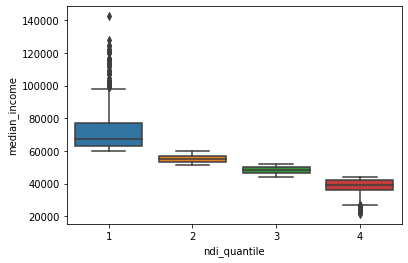

In [72]:
#inspect example data
import seaborn as sns
sns.boxplot(x='ndi_quantile',y='median_income',data=pca)

##### Merge data

In [73]:
#rename and reformat variables before merging
pca = pca[['state_county_fips','NAME','ndi_quantile']]
pca.rename(columns={'NAME':'county_name'}, inplace=True)
pca['state_county_fips'] = pca['state_county_fips'].astype(str).str.zfill(5)

In [74]:
#rename feed columns before merging
feed.rename(columns={'state':'state_abb'}, inplace=True)

In [75]:
#merge ndi data with feed data
feed = feed.merge(pca, on='state_county_fips', how='left')

In [76]:
feed.isna().sum()

url                          0
donation_count               0
donor_reached_max            0
currencycode                 0
current_amount               0
goal_amount                  0
fund_name                    1
fund_description             0
created_at                   0
social_share_last_update     0
city                         0
country                      0
postal_code                  0
is_team                      0
year                         0
month                        0
state_abb                    0
zip_len                      0
zip                          0
state_county_fips            0
county_name                 37
ndi_quantile                37
dtype: int64

In [77]:
#inspect missing data
feed[feed['county_name'].isna()]['state_abb'].value_counts()

GU    22
MP     7
SD     4
AK     2
PR     1
AS     1
Name: state_abb, dtype: int64

### Add state data

In [78]:
#state data
import utils
state_list = utils.state_list
state_abb = utils.us_state_abbrev
state_abb = {v:k for k,v in state_abb.items()}

#### Add state name from abbreviations

In [79]:
feed['state_name'] = feed['state_abb'].map(state_abb)

#### Add state population and FIPS

In [80]:
#get population by state from census api
vars_to_get = 'DP05_0001E' #population

base_request = ("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,"+
                    vars_to_get+
                    "&for=state:*&key=")

full_request = base_request + census_key

r = requests.get(full_request)
r_json = r.json()
state_pop = pd.DataFrame(data=r_json[1:][:], columns=r_json[0][:])
state_pop.columns = ['state_name','state_population','state_fips']

state_pop.to_csv('../data/census/state_pop.csv', index=False)

In [81]:
feed = feed.merge(state_pop, on='state_name', how='left')

#### Add census regions

In [82]:
#import census regions
census_regions = pd.read_csv('../data/census/census_regions.csv')
census_regions.columns = ['state_name','state_abb','census_region','census_division']
del census_regions['state_abb'] #redundant

In [83]:
#merge census regions
feed = feed.merge(census_regions, on='state_name', how='left')

#### Remove locations that are not US 50 states + DC

In [84]:
feed = feed[feed['state_abb'].isin(state_list)]

In [85]:
feed.shape

(92294, 27)

### Check NA values

In [86]:
feed.isnull().sum()

url                         0
donation_count              0
donor_reached_max           0
currencycode                0
current_amount              0
goal_amount                 0
fund_name                   1
fund_description            0
created_at                  0
social_share_last_update    0
city                        0
country                     0
postal_code                 0
is_team                     0
year                        0
month                       0
state_abb                   0
zip_len                     0
zip                         0
state_county_fips           0
county_name                 6
ndi_quantile                6
state_name                  0
state_population            0
state_fips                  0
census_region               0
census_division             0
dtype: int64

In [87]:
#inspect county name
feed[feed['county_name'].isna()]

,url,donation_count,donor_reached_max,currencycode,current_amount,goal_amount,fund_name,fund_description,created_at,social_share_last_update,...,zip_len,zip,state_county_fips,county_name,ndi_quantile,state_name,state_population,state_fips,census_region,census_division
679,https://www.gofundme.com/f/Lakin,79,0,USD,4120.0,4500.0,New Wheelchair: Lakin Little Eagle,<strong>The Mita Oyate Community asks for your...,2015-01-25T15:53:37-06:00,2017-08-30T19:16:16-05:00,...,5,57770,46113,NaN,NaN,South Dakota,870638,46,Midwest,West North Central
4813,https://www.gofundme.com/f/baby-arya,18,0,USD,1590.0,1500.0,Baby Arya,"Hi, my name is Arya. My parents are Addie Prin...",2018-11-27T12:54:07-06:00,2018-12-23T15:52:37-06:00,...,5,99658,02270,NaN,NaN,Alaska,737068,02,West,Pacific
9501,https://www.gofundme.com/f/1uzq99iylc,8,0,USD,475.0,400.0,Oglala Womens Healing Circle: Mind Body Medicine,My name is Cynthia New Holy I have started a w...,2020-01-06T21:33:23-06:00,2020-07-19T13:05:12-05:00,...,5,57764,46113,NaN,NaN,South Dakota,870638,46,Midwest,West North Central
18684,https://www.gofundme.com/f/storhmstrong,15,0,USD,715.0,3000.0,StorhmStrong,"<img class=""not-resizeable"" src=""https://d2g8i...",2019-05-16T10:29:55-05:00,2019-07-30T10:01:22-05:00,...,5,57772,46113,NaN,NaN,South Dakota,870638,46,Midwest,West North Central
26210,https://www.gofundme.com/f/relocating-to-omaha,12,0,USD,495.0,5000.0,Remaining in Omaha,\n<p> Tim has been battling liver cancer since...,2019-11-04T20:23:38-06:00,2019-11-11T07:18:39-06:00,...,5,57772,46113,NaN,NaN,South Dakota,870638,46,Midwest,West North Central
89063,https://www.gofundme.com/f/qwk92-my-daughter03...,8,0,USD,350.0,6000.0,My Daughter's Wish,"I'm going WAY out of my comfort zone, but for ...",2020-07-12T09:52:30-05:00,,...,5,99620,02270,NaN,NaN,Alaska,737068,02,West,Pacific


In [88]:
#remove missing county name
feed = feed[~feed['county_name'].isna()]

In [89]:
#fill NA fund name with blank string
feed['fund_name'] = feed['fund_name'].fillna(' ')

In [90]:
feed.shape

(92288, 27)

In [91]:
#recheck NA
feed.isna().sum()

url                         0
donation_count              0
donor_reached_max           0
currencycode                0
current_amount              0
goal_amount                 0
fund_name                   0
fund_description            0
created_at                  0
social_share_last_update    0
city                        0
country                     0
postal_code                 0
is_team                     0
year                        0
month                       0
state_abb                   0
zip_len                     0
zip                         0
state_county_fips           0
county_name                 0
ndi_quantile                0
state_name                  0
state_population            0
state_fips                  0
census_region               0
census_division             0
dtype: int64

### Identify campaigns with "research" in title

In [92]:
feed.loc[:,'research_in_title'] = (feed['fund_name'].str.lower().str.contains('research'))
feed['research_in_title'] = feed['research_in_title'].astype(int)

### Clean text data

In [93]:
def CleanText(t):
    '''
    input: text string t
    output: cleaned text string r
    '''
    
    #regular expression to remove url
    url_reg = r'(?:(?:http|https):\/\/)?([-a-zA-Z0-9.]{2,256}\.[a-z]{2,4})\b(?:\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?'
    
    #regular expression to remove emojis
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)
    
    #strip html elements, replace line breaks and alternative characters
    r = bs(t).get_text()
    r = r.replace("\n","")
    r = r.replace(u'\xa0', u' ')
    
    #strip urls
    r = re.sub(url_reg,'',r)
    
    #strip emojis
    r = re.sub(emoji_pattern,'',r)
    
    #strip leading and trailing whitespace
    r = r.strip()
    
    #return response
    return r

In [94]:
#apply cleaning function, takes about a minute
feed.loc[:,'fund_description_clean'] = [CleanText(x) for x in feed['fund_description']]

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [95]:
#inspect a few

print(feed['fund_description'][100][:500])
print("\n")
print(feed['fund_description_clean'][100][:500])
print("\n")
print(feed['fund_description'][60005][:500])
print("\n")
print(feed['fund_description_clean'][60005][:500])

The picture that we posted is of our family before we were overwhelmed by medical debt. It also represents how we once again hope to be. That day when we will once again be able to afford to live in our home. Like so many people today, we are working as hard as we can, and doing as much as we can to keep up, however it's just not enough. <br /><br />It's difficult to ask for help. It is very hard to admit that you cannot do what needs to be done. We have been trying since 2005 to pay all of the 


The picture that we posted is of our family before we were overwhelmed by medical debt. It also represents how we once again hope to be. That day when we will once again be able to afford to live in our home. Like so many people today, we are working as hard as we can, and doing as much as we can to keep up, however it's just not enough. It's difficult to ask for help. It is very hard to admit that you cannot do what needs to be done. We have been trying since 2005 to pay all of the medical r

In [96]:
#remove raw text and replace with cleaned text
del feed['fund_description']
feed = feed.rename(columns={'fund_description_clean':'fund_description'})

### Identify non-English campaigns

In [97]:
def GetLanguage(df):
    path_to_pretrained_model = '../data/fasttext_models/lid.176.bin'
    fmodel = fasttext.load_model(path_to_pretrained_model)
    r = fmodel.predict(feed['fund_description'].to_list())
    labels = r[0]
    labels = [i[0].split('__')[2] for i in labels]
    scores = r[1]
    scores = [i[0] for i in scores]
    return labels, scores

In [98]:
#apply function, takes about a minute
feed.loc[:,'language'], feed.loc[:,'language_score'] = GetLanguage(feed)

### Add donations statistics

In [99]:
#inspect donation data
donation.head()

,don_id,online_id,url,don_amt,don_offline,don_anon,don_name,don_date,don_profile,don_verified
0,1,75288239,https://www.gofundme.com/f/Amarilindo,10.0,0,0,Patrice Whitely,2016-03-13T16:09:18-05:00,,1
1,2,72701479,https://www.gofundme.com/f/Amarilindo,20.0,0,0,cheryl redman,2016-03-03T07:19:35-06:00,,1
2,3,72113923,https://www.gofundme.com/f/Amarilindo,25.0,0,0,Stephanie C,2016-03-01T08:44:25-06:00,,1
3,4,71698975,https://www.gofundme.com/f/Amarilindo,30.0,0,0,Tracy H,2016-02-28T12:22:35-06:00,,1
4,5,71101151,https://www.gofundme.com/f/Amarilindo,50.0,0,0,Yosh Takashima,2016-02-25T18:45:31-06:00,,1


In [100]:
don = donation[['url','don_amt']].groupby('url').agg(['min', 'max','mean','median'])

In [101]:
don = don.reset_index()

In [102]:
don.columns = don.columns.droplevel(0)

In [103]:
don.columns = ['url','donation_min','donation_max','donation_mean','donation_median']

In [104]:
master = feed.merge(don, how='left', on='url')

In [105]:
master.shape

(92288, 34)

### Add update statistics

In [106]:
#inspect updates data
update.head()

,update_id,id,author,author_type,user_profile_url,media_type,status,update_text,created_at,url,photo_url,update_data_error
0,1,7264789,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,It&#039;s been a very scary month for me. I ha...,2016-03-01T06:14:33-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
1,2,7071131,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,This is Amari&#039;s vitals today!,2016-02-19T09:04:17-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
2,3,7071069,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,Amari has come a long way since we first came ...,2016-02-19T09:00:39-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
3,4,7029203,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,Last night Amari&#039;s sister Brooke-Lynn who...,2016-02-17T05:52:07-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
4,5,6705617,Janet Stern Capron,ORGANIZER,https://graph.facebook.com/v7.0/10208115198308...,1,1,"Dear friends of Antony,\r\nJust a brief update...",2016-01-28T23:52:24-06:00,https://www.gofundme.com/f/m6gg66vd,None,None


In [107]:
up = pd.DataFrame(update['url'].value_counts()).reset_index().rename(columns={'index':'url','url':'update_count'})

In [108]:
up.head()

,url,update_count
0,https://www.gofundme.com/f/dhe0h0,153
1,https://www.gofundme.com/f/terrystransplant,153
2,https://www.gofundme.com/f/ajb8nz64,153
3,https://www.gofundme.com/f/help-ric-fight-cancer,153
4,https://www.gofundme.com/f/gr9p9c,153


In [109]:
master = master.merge(up, how='left', on='url')

### Check dataset for missing data and size

In [110]:
master.shape

(92288, 35)

In [111]:
sum(master.isna().sum() > 0)

5

In [112]:
master.isna().sum().tail(10)

census_division          0
research_in_title        0
fund_description         0
language                 0
language_score           0
donation_min          1999
donation_max          1999
donation_mean         1999
donation_median       1999
update_count         29096
dtype: int64

- Many campaigns do not have updates, so missing data for update_count is fine.
- Inspect donation data more

In [113]:
sum(master['donation_count'] == 0)

1955

Most missing donation data is due to campaigns that have no donations.

n=44 campaigns do not have available donation data.

In [114]:
master[(master['donation_count'] > 0)&(master['donation_min'].isna())]

,url,donation_count,donor_reached_max,currencycode,current_amount,goal_amount,fund_name,created_at,social_share_last_update,city,...,census_division,research_in_title,fund_description,language,language_score,donation_min,donation_max,donation_mean,donation_median,update_count
6321,https://www.gofundme.com/f/qzd2e-respite-care,18,0,USD,1630.0,2500.0,Respite care,2020-02-28T16:27:20-06:00,2020-03-10T18:02:58-05:00,"San Diego, CA",...,Pacific,0,My name is Marie. My husband and I have been t...,en,0.982713,NaN,NaN,NaN,NaN,2.0
6568,https://www.gofundme.com/f/help-ursula-get-peace,12,0,USD,1550.0,20000.0,Help Ursula get peace,2018-06-06T07:32:40-05:00,2018-06-07T17:50:44-05:00,"Fort Lauderdale, FL",...,South Atlantic,0,"Ursula is a 57 year old mom, wife, daughter, s...",en,0.979423,NaN,NaN,NaN,NaN,1.0
7409,https://www.gofundme.com/f/roclathon-2020,7,0,USD,200.0,3000.0,Rock-A-Thon 2020,2020-02-26T08:27:15-06:00,2020-03-12T14:39:55-05:00,"Altoona, PA",...,Middle Atlantic,0,UPDATE: Thank you so much to everyone who as a...,en,0.942339,NaN,NaN,NaN,NaN,NaN
8208,https://www.gofundme.com/f/help-support-helen-...,6,0,USD,600.0,50000.0,Help Support Helen Iaconelli Through Her Fight,2020-02-21T09:36:11-06:00,,"Woodbine, NJ",...,Middle Atlantic,0,"As some may already know, Helen was surprising...",en,0.973820,NaN,NaN,NaN,NaN,1.0
8685,https://www.gofundme.com/f/hezkjg-it-takes-a-v...,30,0,USD,1785.0,7000.0,It takes a Village,2020-02-27T07:05:39-06:00,2020-05-29T05:27:47-05:00,"Saint Cloud, FL",...,South Atlantic,0,I'm not even sure where to start. Never done ...,en,0.981220,NaN,NaN,NaN,NaN,3.0
10170,https://www.gofundme.com/f/5ru6y-hope-for-melanie,6,0,USD,295.0,1000000.0,Hope For Melanie,2020-02-11T13:36:38-06:00,,"Huntsville, AR",...,West South Central,0,You are about to read a description of a woman...,en,0.985378,NaN,NaN,NaN,NaN,NaN
12480,https://www.gofundme.com/f/heart-sugery-for-mark,10,0,USD,1850.0,30000.0,Heart Surgery for Mark Kucel,2018-08-06T10:07:14-05:00,2018-10-18T15:27:19-05:00,"Saint Clair Shores, MI",...,East North Central,0,Mark Kucel is having heart surgery to correct ...,en,0.980694,NaN,NaN,NaN,NaN,2.0
12987,https://www.gofundme.com/f/rainbows-for-sick-kids,7,0,USD,260.0,1000.0,Rainbows for Sick Kids,2020-02-21T15:46:07-06:00,,"Madison, WI",...,East North Central,0,I am trying to raise money to buy rainbow sun ...,en,0.936645,NaN,NaN,NaN,NaN,1.0
17752,https://www.gofundme.com/f/1xa5nb0iao,9,0,USD,235.0,1200.0,Recaudando Fondos Para Anayeli Samantha Reyes,2020-03-10T16:23:43-05:00,2020-03-12T04:41:45-05:00,"Oklahoma City, OK",...,West South Central,0,Estamos recaudando fondos para ayudar a Anayel...,en,0.542709,NaN,NaN,NaN,NaN,NaN
18011,https://www.gofundme.com/f/jens-fight-for-a-ki...,6,0,USD,228.0,25000.0,Jen’s Fight For A Kidney,2020-02-23T20:33:57-06:00,,"Hamilton, OH",...,East North Central,0,I worked with Jen years ago in the ER. Jentook...,en,0.974186,NaN,NaN,NaN,NaN,NaN


# Apply exclusions

In [11]:
#starting sample size
print(original_n)

99943


In [12]:
#duplicate campaigns removed
print(duplicated_n)

6981


In [ ]:
#unidentifiable location data removed

In [ ]:
#remove non-english campaigns
master = master[master['language'] == 'en']
print(master.shape)

In [ ]:
#remove campaigns with currency != USD
master = master[master['currencycode'] == 'USD']
print(master.shape)

In [ ]:
#remove campaigns with "research" in title
master = master[master['research_in_title'] == 0]
print(master.shape)

### Save data to database

In [115]:
master.to_sql('master', con=conn, if_exists='replace')

### Test that save to db worked

In [116]:
pd.read_sql_query("SELECT COUNT(*) FROM master", conn)

,COUNT(*)
0,92288
